In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from tqdm.autonotebook import tqdm

from xhistogram.xarray import histogram
import cartopy.crs as ccrs
import cartopy
import matplotlib.ticker as mticker
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127


In [3]:
#df_3hr_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr')]
df_Omon_uo = df[(df.table_id == 'Omon') & (df.variable_id == 'vo') & (df.source_id == 'GFDL-CM4')]#& (df.activity_id == 'CMIP')]
len(df_Omon_uo)

6

In [4]:
#df_3hr_pr.head()
df_Omon_uo.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
67218,CMIP,NOAA-GFDL,GFDL-CM4,1pctCO2,r1i1p1f1,Omon,vo,gn,gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/1pctCO2/r1i...,NaN,20180701
67331,CMIP,NOAA-GFDL,GFDL-CM4,abrupt-4xCO2,r1i1p1f1,Omon,vo,gn,gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/abrupt-4xCO...,NaN,20180701
67539,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Omon,vo,gn,gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/historical/...,NaN,20180701
67720,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,vo,gn,gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r...,NaN,20180701
279241,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp245,r1i1p1f1,Omon,vo,gn,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp2...,NaN,20180701


In [5]:
#df_3hr_pr.groupby(['experiment_id', 'source_id'])['zstore'].count()
df_Omon_uo.groupby(['experiment_id', 'source_id'])['zstore'].count()

experiment_id  source_id
1pctCO2        GFDL-CM4     1
abrupt-4xCO2   GFDL-CM4     1
historical     GFDL-CM4     1
piControl      GFDL-CM4     1
ssp245         GFDL-CM4     1
ssp585         GFDL-CM4     1
Name: zstore, dtype: int64

In [6]:
run_counts = df_Omon_uo.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id  experiment_id
GFDL-CM4   1pctCO2          1
           abrupt-4xCO2     1
           historical       1
           piControl        1
           ssp245           1
           ssp585           1
Name: zstore, dtype: int64

In [7]:
source_ids = []
experiment_ids = ['piControl']
#for name, group in df_3hr_pr.groupby('source_id'):
for name, group in df_Omon_uo.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

['GFDL-CM4']

In [8]:
def load_pr_data(source_id, expt_id):
    """
    Load 3hr precip data for given source and expt ids
    """
 #   uri = df_3hr_pr[(df_3hr_pr.source_id == source_id) &
 #                        (df_3hr_pr.experiment_id == expt_id)].zstore.values[0]
    uri = df_Omon_uo[(df_Omon_uo.source_id == source_id) &
                         (df_Omon_uo.experiment_id == expt_id)].zstore.values[0]
   
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [9]:
source_ids

['GFDL-CM4']

In [10]:
results = {}
for source_id in tqdm(source_ids):
    ds = load_pr_data(source_id, 'piControl')


In [12]:
ds.lev[:]

<xarray.DataArray 'lev' (lev: 35)>
array([2.5000e+00, 1.0000e+01, 2.0000e+01, 3.2500e+01, 5.1250e+01, 7.5000e+01,
       1.0000e+02, 1.2500e+02, 1.5625e+02, 2.0000e+02, 2.5000e+02, 3.1250e+02,
       4.0000e+02, 5.0000e+02, 6.0000e+02, 7.0000e+02, 8.0000e+02, 9.0000e+02,
       1.0000e+03, 1.1000e+03, 1.2000e+03, 1.3000e+03, 1.4000e+03, 1.5375e+03,
       1.7500e+03, 2.0625e+03, 2.5000e+03, 3.0000e+03, 3.5000e+03, 4.0000e+03,
       4.5000e+03, 5.0000e+03, 5.5000e+03, 6.0000e+03, 6.5000e+03])
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Attributes:
    axis:         Z
    bounds:       lev_bnds
    description:  generic ocean model vertical coordinate (nondimensional or ...
    long_name:    ocean model level
    positive:     down
    units:        m

In [13]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lev: 35, time: 6000, x: 1440, y: 1080)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    lat        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * time       (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    vo         (time, lev, y, x) float32 dask.array<chunksize=(1, 35, 1080, 1440), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54750.0
    comment:                <null ref>
    contact:                gfdl.climate.model.info@noaa.gov
    creation_date:          2019-02-07T19:29:11Z
    data_specs_version:     01.00.27
    experiment:             pre-industrial control
    experiment_id:          piControl
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.GF...
    grid:                   ocean data on native grid tripolar - nominal 0.25...
    grid_label:             gn
    history:                File was processed by fremetar (GFDL analog of CM...
    initialization_index:   1
    institution:            National Oceanic and Atmospheric Administration, ...
    institution_id:         NOAA-GFDL
    license:                CMIP6 model data produced by NOAA-GFDL is license...
    mip_era:                CMIP6
    nominal_resolution:     25 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl-spinup
    parent_mip_era:         CMIP6
    parent_source_id:       GFDL-CM4
    parent_time_units:      days since 1700-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  ocean
    references:             see further_info_url attribute
    source:                 GFDL-CM4 (2018): \naerosol: interactive\natmos: G...
    source_id:              GFDL-CM4
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Omon
    title:                  NOAA GFDL GFDL-CM4 model output prepared for CMIP...
    tracking_id:            hdl:21.14100/1c3b9051-f6a2-477e-9f36-88ca02cd8aab...
    variable_id:            vo
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu

In [14]:
ds.lev_bnds

<xarray.DataArray 'lev_bnds' (lev: 35, bnds: 2)>
dask.array<zarr, shape=(35, 2), dtype=float64, chunksize=(35, 2), chunktype=numpy.ndarray>
Coordinates:
  * bnds      (bnds) float64 1.0 2.0
  * lev       (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lev_bnds  (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>

In [15]:
uo = ds.vo.isel(time=[0],lev=[0],x=slice(800,880),y=slice(551,638))
lons=np.asarray(uo.lon)
lats=np.asarray(uo.lat)
data=np.asarray(uo[0,0,:,:])
uo

<xarray.DataArray 'vo' (time: 1, lev: 1, y: 87, x: 80)>
dask.array<getitem, shape=(1, 1, 87, 80), dtype=float32, chunksize=(1, 1, 87, 80), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(87, 80), meta=np.ndarray>
  * lev      (lev) float64 2.5
    lon      (y, x) float32 dask.array<chunksize=(87, 80), meta=np.ndarray>
  * time     (time) object 0151-01-16 12:00:00
  * x        (x) float64 -99.87 -99.62 -99.36 -99.11 ... -80.3 -80.05 -79.8
  * y        (y) float64 11.91 12.16 12.4 12.65 12.89 ... 31.1 31.31 31.53 31.74
Attributes:
    cell_methods:   time: mean
    interp_method:  none
    long_name:      Sea Water Y Velocity
    original_name:  vo
    standard_name:  sea_water_y_velocity
    units:          m s-1

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


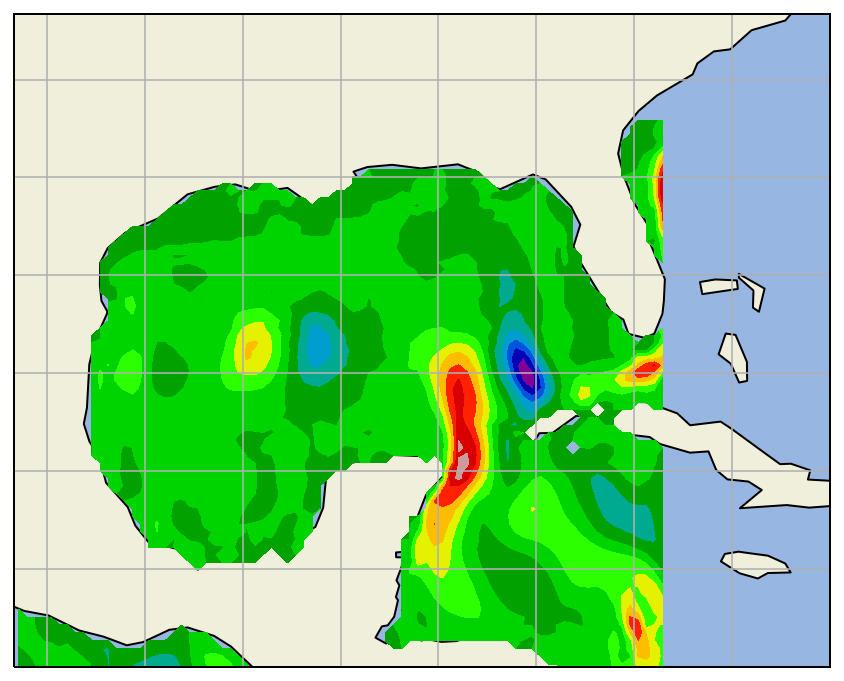

In [16]:
import cartopy.feature as cfeature
fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1, projection==ccrs.PlateCarree())#ccrs.Orthographic(-60, -45))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-100, -75, 15, 35], crs=ccrs.PlateCarree())
#ax.set_extent([-110, -20, -10, 50], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')

#ax.set_global()
ax.gridlines()


ax.contourf(lons, lats, data,
            transform=ccrs.PlateCarree(),
            cmap='nipy_spectral',vmin = -1 , vmax=1 , levels=17)


/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


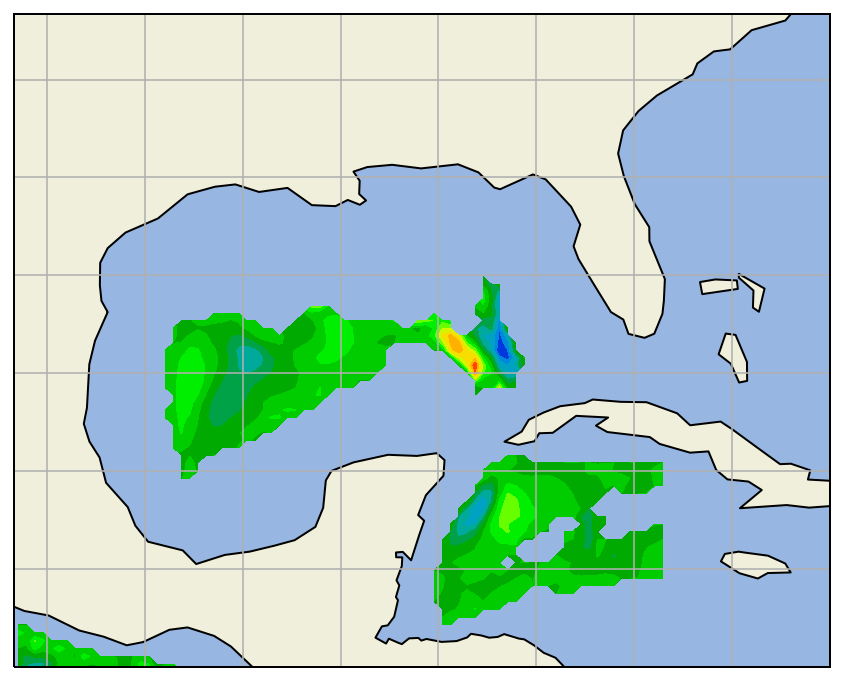

In [28]:
uo = ds.vo.isel(time=[0],lev=[28],x=slice(800,880),y=slice(551,638))
lons=np.asarray(uo.lon)
lats=np.asarray(uo.lat)
data=np.asarray(uo[0,0,:,:])

fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1, projection==ccrs.PlateCarree())#ccrs.Orthographic(-60, -45))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-100, -75, 15, 35], crs=ccrs.PlateCarree())
#ax.set_extent([-110, -20, -10, 50], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')

#ax.set_global()
ax.gridlines()


ax.contourf(lons, lats, data,
            transform=ccrs.PlateCarree(),
            cmap='nipy_spectral',vmin = -0.1 , vmax=0.1 , levels=17)

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


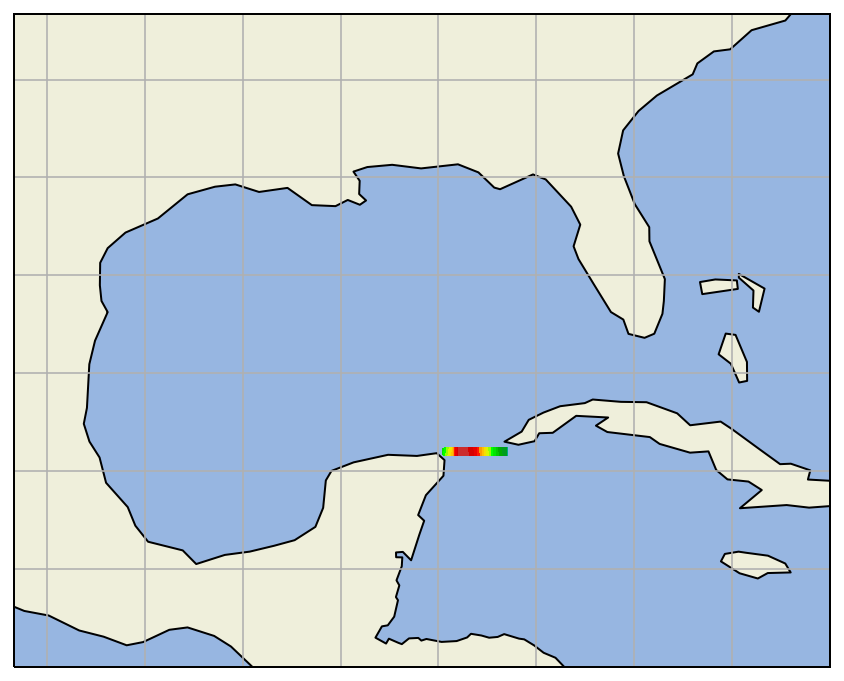

In [17]:

uo = ds.vo.isel(time=[0],lev=[0],x=slice(852,861),y=slice(591,593))
lons=np.asarray(uo.lon)
lats=np.asarray(uo.lat)
data=np.asarray(uo[0,0,:,:])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-100, -75, 15, 35], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.gridlines()
ax.contourf(lons, lats, data,
            transform=ccrs.PlateCarree(),
            cmap='nipy_spectral',vmin = -1 , vmax=1 , levels=17)

In [37]:
uo = ds.vo.isel(time=slice(0,20),lev=slice(0,30),x=slice(852,861),y=slice(591,593))
uo=uo.mean(dim='y',skipna=True).mean(dim='time',skipna=True)
for i in range(27):
    if i ==0:
        #print('ololo')
        #depths.append(2.5)
        uo.isel(lev=[i])*2.5*111*np.cos(21)/4
    else:
        print(i)
        #depths.append(ds.lev[i]-ds.lev[i-1])
        uo.isel(lev=[i])*(ds.lev[i]-ds.lev[i-1])*111*np.cos(21)/4
print(uo)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
<xarray.DataArray 'vo' (lev: 30, x: 9)>
dask.array<mean_agg-aggregate, shape=(30, 9), dtype=float32, chunksize=(30, 9), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 2.5e+03 3e+03 3.5e+03 4e+03
  * x        (x) float64 -86.65 -86.4 -86.14 -85.89 ... -85.13 -84.87 -84.62


/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/plot/utils.py:624: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(primitive, **cbar_kwargs)


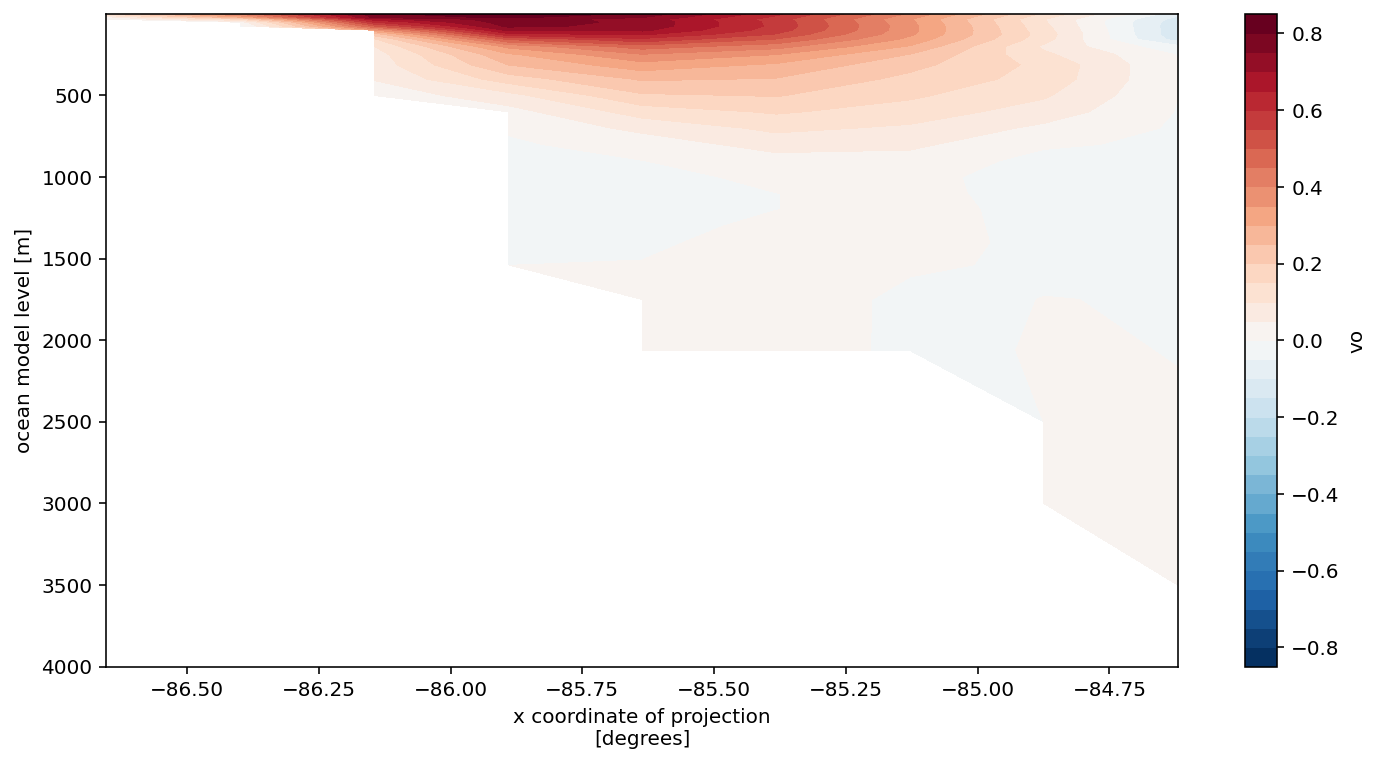

In [39]:
uo.plot.contourf(levels=40, add_colorbar=True)
plt.gca().invert_yaxis()

In [18]:
uo = ds.vo.isel(x=slice(852,861),y=slice(591,593))
print(len(uo[0,:,0,0]))
print(uo[0,:,0,0])
depths=[]
#27 ; 35
#for i in range(len(ds.uo.lev)):
for i in range(27):
    if i ==0:
        #print('ololo')
        #depths.append(2.5)
        uo.isel(lev=[i])*2.5*111*np.cos(21)/4
    else:
        print(i)
        #depths.append(ds.lev[i]-ds.lev[i-1])
        uo.isel(lev=[i])*(ds.lev[i]-ds.lev[i-1])*111*np.cos(21)/4
print(uo)

uo=uo.mean(dim='y',skipna=True).mean(dim='time',skipna=True)
#GOM_prof = uo.sum(dim='x',skipna=True).sum(dim='lev',skipna=True)

#uo = uo.mean(dim='y',skipna=True).sum(dim='lev',skipna=True)
#GOM_prof = uo.sum(dim='y',skipna=True).sum(dim='lev',skipna=True)
#ACC.plot.line()

35
<xarray.DataArray 'vo' (lev: 35)>
dask.array<getitem, shape=(35,), dtype=float32, chunksize=(35,), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 dask.array<chunksize=(), meta=np.ndarray>
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lon      float32 dask.array<chunksize=(), meta=np.ndarray>
    time     object 0151-01-16 12:00:00
    x        float64 -86.65
    y        float64 21.48
Attributes:
    cell_methods:   time: mean
    interp_method:  none
    long_name:      Sea Water Y Velocity
    original_name:  vo
    standard_name:  sea_water_y_velocity
    units:          m s-1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
<xarray.DataArray 'vo' (time: 6000, lev: 35, y: 2, x: 9)>
dask.array<getitem, shape=(6000, 35, 2, 9), dtype=float32, chunksize=(1, 35, 2, 9), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(2, 9), meta=np.ndarray>
  * lev      (lev) float64 2.5 10.0 20.

In [19]:
uo = ds.vo.isel(x=slice(852,861),y=slice(591,593))
print(len(uo[0,:,0,0]))
print(uo[0,:,0,0])
depths=[]
#27 ; 35
#for i in range(len(ds.uo.lev)):
for i in range(27,35):
    if i ==0:
        #print('ololo')
        #depths.append(2.5)
        uo.isel(lev=[i])*2.5*111*np.cos(21)/4
    else:
        print(i)
        #depths.append(ds.lev[i]-ds.lev[i-1])
        uo.isel(lev=[i])*(ds.lev[i]-ds.lev[i-1])*111*np.cos(21)/4
print(uo)

ACC_deep = uo.sum(dim='y',skipna=True).sum(dim='lev',skipna=True)

35
<xarray.DataArray 'vo' (lev: 35)>
dask.array<getitem, shape=(35,), dtype=float32, chunksize=(35,), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 dask.array<chunksize=(), meta=np.ndarray>
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lon      float32 dask.array<chunksize=(), meta=np.ndarray>
    time     object 0151-01-16 12:00:00
    x        float64 -86.65
    y        float64 21.48
Attributes:
    cell_methods:   time: mean
    interp_method:  none
    long_name:      Sea Water Y Velocity
    original_name:  vo
    standard_name:  sea_water_y_velocity
    units:          m s-1
27
28
29
30
31
32
33
34
<xarray.DataArray 'vo' (time: 6000, lev: 35, y: 2, x: 9)>
dask.array<getitem, shape=(6000, 35, 2, 9), dtype=float32, chunksize=(1, 35, 2, 9), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(2, 9), meta=np.ndarray>
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lo

In [18]:
data_surf=[]
data_deep=[]
for i in range(len(ACC_surf)):
    tt=np.asarray(ACC_surf[i])
    data_surf.append(tt)
    tt=np.asarray(ACC_deep[i])
    data_deep.append(tt)
    print(i)

<xarray.DataArray 'uo' (time: 1, lev: 1, y: 87, x: 1)>
dask.array<getitem, shape=(1, 1, 87, 1), dtype=float32, chunksize=(1, 1, 87, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(87, 1), meta=np.ndarray>
  * lev      (lev) float64 2.5
    lon      (y, x) float32 dask.array<chunksize=(87, 1), meta=np.ndarray>
  * time     (time) object 0151-01-16 12:00:00
  * x        (x) float64 -65.6
  * y        (y) float64 -65.7 -65.6 -65.5 -65.39 ... -55.49 -55.35 -55.21
Attributes:
    cell_methods:   time: mean
    interp_method:  none
    long_name:      Sea Water X Velocity
    original_name:  uo
    standard_name:  sea_water_x_velocity
    units:          m s-1